#Question 1

In [72]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pandas
!pip install torch-summary

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [73]:
import torch #python #keras #tensorflow #pytorch
import torch.nn as nn
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.utils import shuffle
from torchsummary import summary

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [75]:
import warnings

def fxn():
  warnings.warn('deprecated', DeprecationWarning)

with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  fxn()

In [76]:

data= pd.read_csv('/content/abalone.data', names=['Sex', 'Length', 'Diameter', 'Heoght', 'Whole Weight', 'Shuckled Weight', 'Viscera Weight', 'Shell Weight', 'Rings'])
print(data.head())
print(data.info())

  Sex  Length  Diameter  Heoght  Whole Weight  Shuckled Weight  \
0   M   0.455     0.365   0.095        0.5140           0.2245   
1   M   0.350     0.265   0.090        0.2255           0.0995   
2   F   0.530     0.420   0.135        0.6770           0.2565   
3   M   0.440     0.365   0.125        0.5160           0.2155   
4   I   0.330     0.255   0.080        0.2050           0.0895   

   Viscera Weight  Shell Weight  Rings  
0          0.1010         0.150     15  
1          0.0485         0.070      7  
2          0.1415         0.210      9  
3          0.1140         0.155     10  
4          0.0395         0.055      7  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              4177 non-null   object 
 1   Length           4177 non-null   float64
 2   Diameter         4177 non-null   float64
 3   Heoght          

In [77]:
print( data['Rings'].value_counts())

9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: Rings, dtype: int64


In [78]:
from sklearn.preprocessing import LabelEncoder
lb_enc= LabelEncoder()

from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

drop=[]

for column in data:
  index=0
  for value in data[column]:
    if data[column].dtype=='object' and value.isnumeric()==True :
      drop.append(index)
    if data[column].dtype!='object' and isinstance(value, int)==False and isinstance(value, float)==False:
      drop.append(index)
    index+=1

data= data.drop( drop)


In [79]:
'''label encoding object columns;'''
data['Sex']= lb_enc.fit_transform( data['Sex'])

scaling_feat=[]
for columns in data:
  if columns!='Sex':
    scaling_feat.append( columns)

data[ scaling_feat]= scaler.fit_transform( data[scaling_feat])


In [81]:
'''further we binerize our data as the lest data is in that format'''

rings= np.array( data['Rings'])
from sklearn.preprocessing import KBinsDiscretizer
transform= KBinsDiscretizer( n_bins=3, encode= 'ordinal', strategy= 'uniform')
rings= np.ravel(transform.fit_transform( rings.reshape( len(rings), 1)))

data['Rings']= rings


In [82]:
'''this completes our preprocessing and now we can split the data'''
from sklearn.model_selection import train_test_split
train, test= train_test_split( data, test_size=0.3, random_state= 42)

X_train, y_train= train.iloc[:, :-1].values, train.iloc[:, -1].values
X_test, y_test= test.iloc[:, :-1].values, test.iloc[:, -1].values 

In [83]:
def acc( batch_size, rings, logit):
  corrects= (torn.max( logit, 1)[1].view( target.size()).data== taregt.data).sum()
  acc= 100.0*corrects/batch_size
  return acc
  

In [84]:
'''lets make our model'''

class Network(torch.nn.Module):
    def __init__(self, num_inputs, size_hidden_1, size_hidden_2, n_output):
        super(Network, self).__init__()
        self.hidden_layer_1 = torch.nn.Linear(num_inputs, size_hidden_1)  
        self.activation_1 = torch.nn.Tanh()
        self.hidden_layer_2 = torch.nn.Linear(num_inputs, size_hidden_2)  
        self.activation_2 = torch.nn.Tanh() 
        
        self.output_layer = torch.nn.Linear(size_hidden_1, n_output) 
        self.output_act = torch.nn.Sigmoid()

    def forward(self, x):
        x1 = self.activation_1(self.hidden_layer_1(x)) 
        x2= self.activation_2(self.hidden_layer_2(x))      
        x3 = torch.add(x2,x1)
        res = self.output_act(self.output_layer(x3))    
        return res



In [85]:
batch_size = 32
num_epochs = 500
size_hidden_1 = 500
size_hidden_2 = 500
learning_rate = 0.05
num_classes = 5
batch_count = len(X_train)//batch_size
cols = X_train.shape[1] 

In [86]:
net = Network(cols, size_hidden_1, size_hidden_2, num_classes)

optim_ = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [87]:
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [88]:
losess = []
for epoch in range(500):
    X_train,y_train = shuffle(X_train, y_train)
    train_accuracy = 0.0
    run_time_loss = 0.0
    for i in range(batch_count):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(X_train[start:end]))
        labels = Variable(torch.LongTensor(y_train[start:end]))
        optim_.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optim_.step()
        run_time_loss += loss.item()
        acc = get_accuracy(outputs, labels, batch_size)
        train_accuracy += acc
    losess.append(run_time_loss/(i+1)) 
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch+1, run_time_loss / (i+1), train_accuracy/(i+1)))  
    run_time_loss = 0.0
  

Epoch: 1 | Loss: 1.1922 | Train Accuracy: 63.56
Epoch: 2 | Loss: 1.1429 | Train Accuracy: 64.19
Epoch: 3 | Loss: 1.1344 | Train Accuracy: 64.02
Epoch: 4 | Loss: 1.1285 | Train Accuracy: 64.25
Epoch: 5 | Loss: 1.1248 | Train Accuracy: 64.13
Epoch: 6 | Loss: 1.1219 | Train Accuracy: 64.13
Epoch: 7 | Loss: 1.1196 | Train Accuracy: 64.27
Epoch: 8 | Loss: 1.1177 | Train Accuracy: 64.40
Epoch: 9 | Loss: 1.1169 | Train Accuracy: 64.23
Epoch: 10 | Loss: 1.1155 | Train Accuracy: 64.36
Epoch: 11 | Loss: 1.1143 | Train Accuracy: 64.68
Epoch: 12 | Loss: 1.1140 | Train Accuracy: 64.54
Epoch: 13 | Loss: 1.1134 | Train Accuracy: 64.65
Epoch: 14 | Loss: 1.1125 | Train Accuracy: 64.78
Epoch: 15 | Loss: 1.1120 | Train Accuracy: 64.92
Epoch: 16 | Loss: 1.1113 | Train Accuracy: 64.95
Epoch: 17 | Loss: 1.1111 | Train Accuracy: 64.96
Epoch: 18 | Loss: 1.1110 | Train Accuracy: 64.90
Epoch: 19 | Loss: 1.1105 | Train Accuracy: 64.98
Epoch: 20 | Loss: 1.1099 | Train Accuracy: 65.20
Epoch: 21 | Loss: 1.1096 | Tr

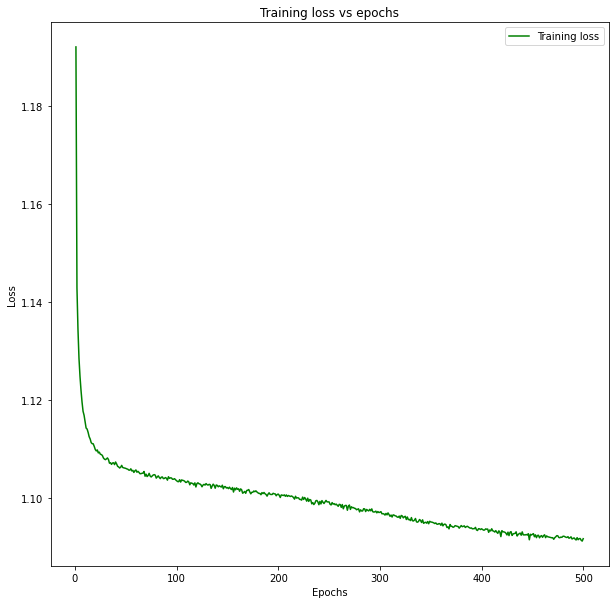

In [89]:
epochs_ = range(1,501)
plt.figure(figsize=(10,10)) 
plt.plot(epochs_, losess, 'g', label='Training loss')
plt.title('Training loss vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Question 2

##Subpart a: Preprocess & visualize the data. Create train, val, and test splits

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [91]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_sets/Dry_Bean_Dataset.csv')
data= data[['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'roundness', 'AspectRation', 'ConvexArea', 'Class']]
#dropping un-necessary features

print(data.head())
print(data.info())

    Area  Perimeter  MajorAxisLength  MinorAxisLength  roundness  \
0  28395    610.291       208.178117       173.888747   0.958027   
1  28734    638.018       200.524796       182.734419   0.887034   
2  29380    624.110       212.826130       175.931143   0.947849   
3  30008    645.884       210.557999       182.516516   0.903936   
4  30140    620.134       201.847882       190.279279   0.984877   

   AspectRation  ConvexArea  Class  
0      1.197191       28715  SEKER  
1      1.097356       29172  SEKER  
2      1.209713       29690  SEKER  
3      1.153638       30724  SEKER  
4      1.060798       30417  SEKER  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             9544 non-null   int64  
 1   Perimeter        9544 non-null   float64
 2   MajorAxisLength  9544 non-null   float64
 3   MinorAxisLength  9544 non-nu

In [92]:
data=data.dropna(subset=['Class'])
#droppin datapoint for the corresponding missing class value

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

class_cat = data[["Class"]]
class_cat_encoded = ordinal_encoder.fit_transform(class_cat)
data['class']= class_cat_encoded.astype(int)
data=data.drop(["Class"], axis=1)
data.info()

'''with our data values available in suitable form and not dire need of scaling,
our data-preprocessing is therefore complete'''

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9543 entries, 0 to 9542
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             9543 non-null   int64  
 1   Perimeter        9543 non-null   float64
 2   MajorAxisLength  9543 non-null   float64
 3   MinorAxisLength  9543 non-null   float64
 4   roundness        9543 non-null   float64
 5   AspectRation     9543 non-null   float64
 6   ConvexArea       9543 non-null   int64  
 7   class            9543 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 671.0 KB


'with our data values available in suitable form and not dire need of scaling,\nour data-preprocessing is therefore complete'

###Visualization and drawing insights

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67f7539490>,
      dtype=object)

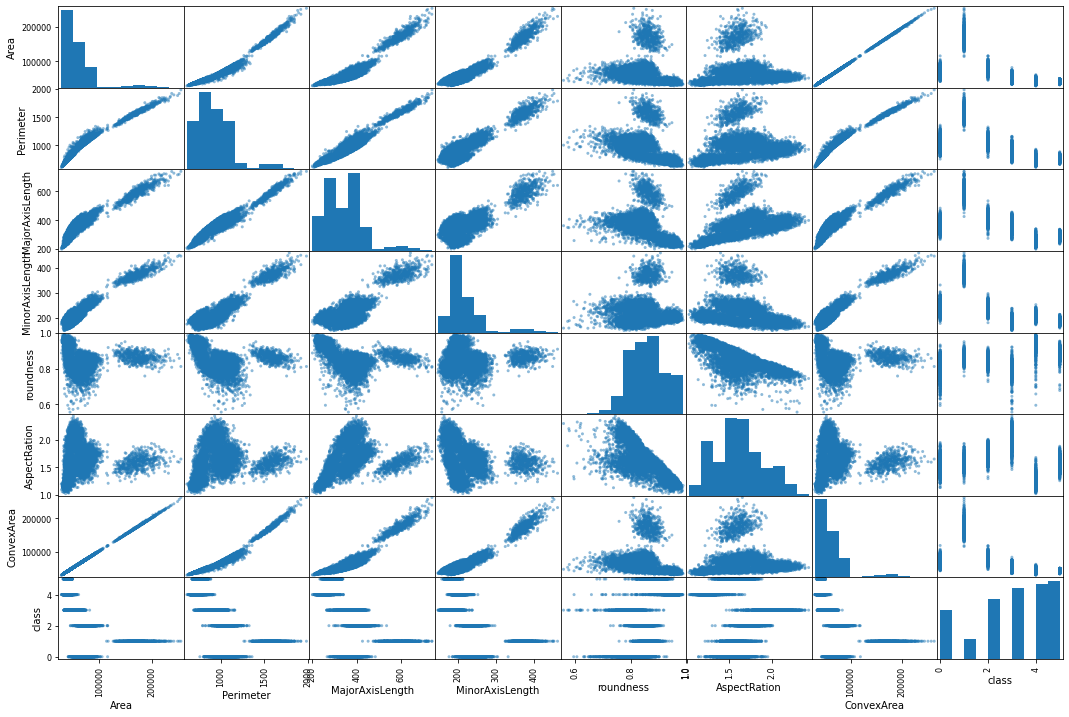

In [93]:
#for better comparisons, lets plot a scatter matrix

from pandas.plotting import scatter_matrix
attributes = data.columns
scatter_matrix(data[attributes], figsize=(18, 12))

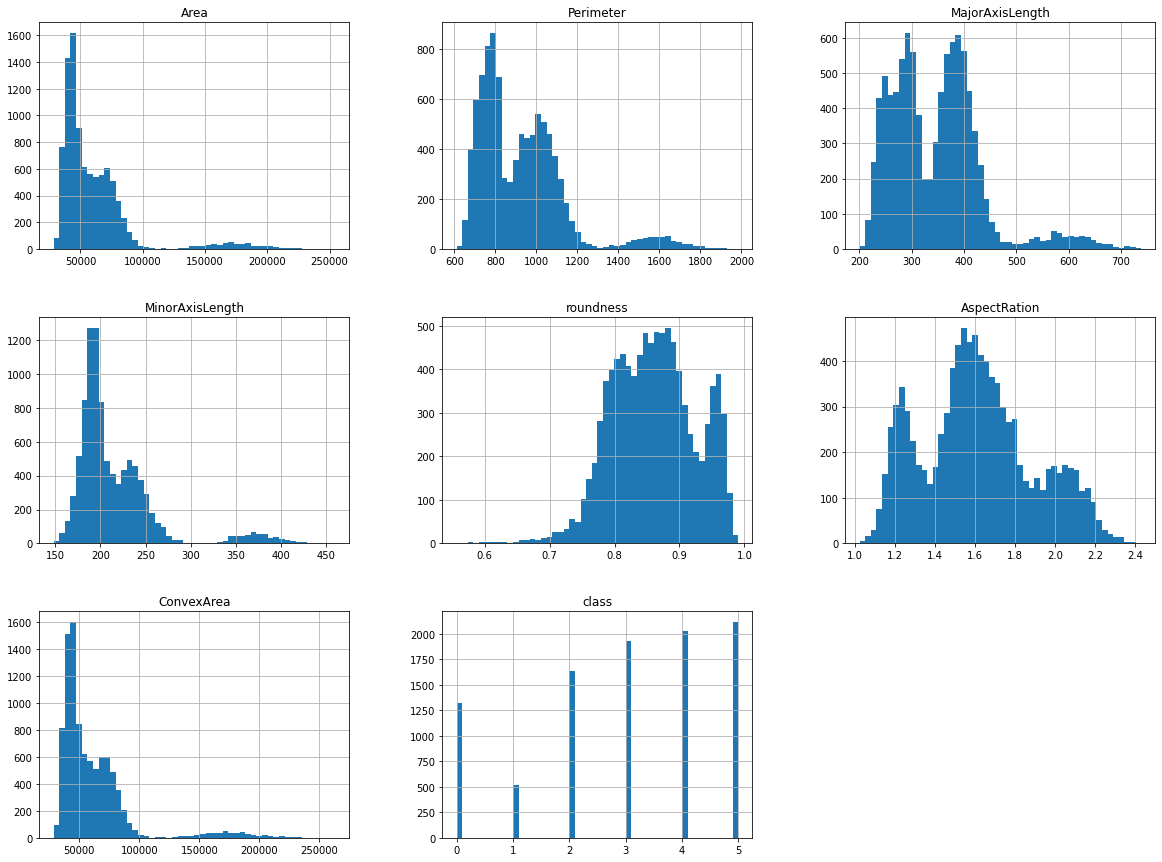

In [94]:
data.hist(bins=50, figsize=(20,15))
plt.show()


In [98]:
'''As we can see that data is skewed, we need to perform stratified sp[lits'''
print('skewness in data features')
print(data.skew())

print('\n\n\ncorrelation bw different features and class')
corr_matrix= data.corr()
print(corr_matrix['class'].sort_values(ascending= False))

skewness in data features
Area               2.753361
Perimeter          1.596199
MajorAxisLength    1.170257
MinorAxisLength    2.272045
roundness         -0.171924
AspectRation       0.269390
ConvexArea         2.741223
class             -0.450031
dtype: float64



correlation bw different features and class
class              1.000000
roundness          0.536573
AspectRation      -0.199286
Area              -0.592376
ConvexArea        -0.595030
MinorAxisLength   -0.604100
MajorAxisLength   -0.637025
Perimeter         -0.706528
Name: class, dtype: float64


'Area', 'MinorAisLength' and 'ConvexArea' are the most skewed features and yet their correlation with 'class' is almost similar with slight variation. For our case, we will stratify-fplit based on 'MinorAxisLength'.

> same was attempted but as The least populated class in MinorAxisLength, Area and ConvexArea has only 1 member, which is too few, we attempt this with 'class'

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
scaler=MinMaxScaler()
label_encoder=LabelEncoder()
X=data.drop(['class'],axis=1)
y=data['class']
X=scaler.fit_transform(X)
y=label_encoder.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42)



##This procedure reduces sampling bais

##Subpart b: Implementing MLP from Scratch

###Activation functions

In [101]:
def relu(x):
  if x<=0:
    return 0
  else:
    return x

def sigm(x):
  y=  1/(1+ np.exp(-x))  
  return y

def tanh(x):
  y = (np.exp(x)- np.exp(-x))/( np.exp(x) + np.exp(-x))
  return y

def i(x):
  return x

###forward propogation

In [102]:
class MLP:
  def __init___(self):
    self.network=[]
    self.layer_count= len(self.network)
    self.neuron_count= []
    self.weights= []
    self.biases= []
    self.activations= []


  def dense( self, neuron_count, active='i'):
    self.neuron_count.append( neuron_count)
    layer= np.zeros( (neuron_count, 1), dtype= float)
    self.network.append(layer)
    self.activations.append(active )
    self.layer_count= len(self.network)

  def init(self):
    for i in range(layer_count-1):
      self.biases.append( np.random.rand())
    
    for i in range(1, layer_count):
      matrix= np.random.randn( neuron_count[i], neuron_count[i-1])
      self.weights.append( matrix)

  def forward(self, x):
    self.network[0]= np.array(x)
    for i in range(1, layer_count):
      bias= np.rand()
      biases.append(bias)
      wx_b= np.array(self.weights[i-1] @ self.network[i-1]) + bias

      if activations[i]=='relu':
        self.network[i]= relu(wx_b)
      elif activations[i]== 'tanh':
        self.network[i]= tanh(wx_b)
      elif activation[i]== 'sigm':
        self.network[i]= sigm(wx_b)
      else:
        self.network[i]= i(wx_b)

      return network[self.layer_count-1]


     

  

In [103]:
# Initialize a network
from random import seed
from random import random


def init(n_inputs, hiddens, n_outputs,activ): 
  '''hiddens is a list
      where length of list is the number of hidden layer we have
      and value at each index is the number of neurons in that list'''
  network = []
  hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(hiddens[0] )] #last element in our weights list is actually the bias term
  hidden_layer.append({'activation': activ[0]})
  network.append(hidden_layer)
 
  for i in range(1, len(hiddens) ): # [1 2]:  i=1
    n_count= hiddens[i] #2
    w_count= hiddens[i-1]+1 #2
    hidden_layer=[] 
    for j in range( n_count): 
      weights=[]
      for k in range( w_count): 
        weights.append( random())
      hidden_layer.append({'weights': weights}) #<<<<<<
    hidden_layer.append({'activation':activ[i]})
    network.append( hidden_layer)

    # hidden_layer = [{'weights':[random() for k in range( hiddens[i-1] + 1)]} for j in range(hiddens[i])]
    # network.append( hidden_layer)

  output_layer = [{'weights':[random() for k in range(hiddens[-1] + 1)]} for j in range(n_outputs)]
  output_layer.append({'activation':activ[-1]})
  network.append(output_layer)
  return network
network = init(2, [1, 2], 2,['relu','relu','relu','relu'])
for layer in network:
  print(layer)


[{'weights': [0.42478092271058443, 0.2270764864906153, 0.7158007080198788]}, {'activation': 'relu'}]
[{'weights': [0.7515321388885964, 0.8333507718218954]}, {'weights': [0.5326494899647429, 0.07717282115116453]}, {'activation': 'relu'}]
[{'weights': [0.7364016241710682, 0.06903578034179925, 0.30417841980735016]}, {'weights': [0.4926471877142311, 0.6957562537781447, 0.8336704930222268]}, {'activation': 'relu'}]


In [104]:
##for constant initializations

def init_k(n_inputs, hiddens, n_outputs,activ): 
  '''hiddens is a list
      where length of list is the number of hidden layer we have
      and value at each index is the number of neurons in that list'''
  k= random()
  network = []
  hidden_layer = [{'weights':[k for i in range(n_inputs + 1)]} for i in range(hiddens[0] )] #last element in our weights list is actually the bias term
  hidden_layer.append({'activation': activ[0]})
  network.append(hidden_layer)
 
  for i in range(1, len(hiddens) ): # [1 2]:  i=1
    n_count= hiddens[i] #2
    w_count= hiddens[i-1]+1 #2
    hidden_layer=[] 
    for j in range( n_count): 
      weights=[]
      for k in range( w_count): 
        weights.append( k)
      hidden_layer.append({'weights': weights}) #<<<<<<
    hidden_layer.append({'activation':activ[i]})
    network.append( hidden_layer)

    # hidden_layer = [{'weights':[k for k in range( hiddens[i-1] + 1)]} for j in range(hiddens[i])]
    # network.append( hidden_layer)

  output_layer = [{'weights':[k for k in range(hiddens[-1] + 1)]} for j in range(n_outputs)]
  output_layer.append({'activation':activ[-1]})
  network.append(output_layer)
  return network



In [105]:
##for 0 initialization

def init_zero(n_inputs, hiddens, n_outputs,activ): 
  '''hiddens is a list
      where length of list is the number of hidden layer we have
      and value at each index is the number of neurons in that list'''
  network = []
  hidden_layer = [{'weights':[0 for i in range(n_inputs + 1)]} for i in range(hiddens[0] )] #last element in our weights list is actually the bias term
  hidden_layer.append({'activation': activ[0]})
  network.append(hidden_layer)
 
  for i in range(1, len(hiddens) ): # [1 2]:  i=1
    n_count= hiddens[i] #2
    w_count= hiddens[i-1]+1 #2
    hidden_layer=[] 
    for j in range( n_count): 
      weights=[]
      for k in range( w_count): 
        weights.append( 0)
      hidden_layer.append({'weights': weights}) #<<<<<<
    hidden_layer.append({'activation':activ[i]})
    network.append( hidden_layer)

    # hidden_layer = [{'weights':[0 for k in range( hiddens[i-1] + 1)]} for j in range(hiddens[i])]
    # network.append( hidden_layer)

  output_layer = [{'weights':[0 for k in range(hiddens[-1] + 1)]} for j in range(n_outputs)]
  output_layer.append({'activation':activ[-1]})
  network.append(output_layer)
  return network

In [106]:
#firing of our neuron

def fire(weights, inputs):
  wx_b = weights[-1]
  # print(len(inputs))
  # print(len(weights))
  for i in range(len(weights)-1): ####
    wx_b += weights[i] * inputs[i]
  

  return wx_b

In [107]:
def forward_propagate(network, data):
	input = data
	for layer in network:
		new_input = []
		# print(layer)
		for neuron in layer[:-1]:
			# print(neuron)
			# print(len( neuron['weights']))
			# print(len(input))
			temp = fire( neuron['weights'], input)
			if layer[-1]['activation']=='relu':
				 neuron['output']= relu(temp)
			elif layer[-1]['activation']=='sigmoid':
				 neuron['output']= sigm(temp)
			elif layer[-1]['activation']=='tanh':
				 neuron['output']= tanh(temp)
			else:
				 neuron['output']= temp
			new_input.append(neuron['output'])
		input = new_input
	return input

network= init( 2, [1, 3, 2], 3,['relu','relu','relu','relu','relu'])
output= forward_propagate( network, [2, 4])
print(output)

[6.456155753510437, 5.7407289405072035, 5.294432035361146]


###Backward Propogation

In [108]:
def anti_activation(x, activation= 'i'):
  if activation=='relu':
    if x>0:
      return 1
    else: return 0 
  if activation=='tanh':
    return 1-x**2
  if activation=='sigm':
    return x*(1-x)
  else:
    return 1



In [109]:

def back_propagate(network, expected):
  for i in range( len(network)- 1, -1, -1):
    layer, error_layer = network[i], []
		
    if i != len(network)-1: #if it isnt the last layer, calculation of error is not staright forward
      for j in range(len(layer)-1):
        error_neuron = 0.0
        for neuron in network[i + 1][:-1]:
          error_neuron += (neuron['weights'][j] * neuron['delta'])
        error_layer.append(error_neuron)
    else: #if it is the last layer, calculation is rather straihtforward<<<<<<<<<<<<<<<<<<<<<
      for j in range(len(layer)-1):
        neuron = layer[j]
        error_layer.append(-neuron['output'] + expected[j])
    
    for j in range(len(layer)-1):
      neuron = layer[j]
      neuron['delta'] = error_layer[j] * anti_activation(neuron['output'],layer[-1]['activation']) 

network = init(2, [1, 2], 2,['relu','relu','relu','relu'])
expected= [1, 2, 3]

output= forward_propagate( network, [2, 4])
back_propagate( network, expected)
for layer in network:
  print(layer)

[{'weights': [0.079245229238471, 0.7264376497163665, 0.3976861245440283], 'output': 3.4619271818864363, 'delta': -1.244901465736759}, {'activation': 'relu'}]
[{'weights': [0.4775008892043393, 0.4533087922374688], 'output': 2.106382099948915, 'delta': -1.345209480562408}, {'weights': [0.6216209449837703, 0.6030428399617486], 'output': 2.755049286230996, 'delta': -0.9693411193180339}, {'activation': 'relu'}]
[{'weights': [0.3105899960533921, 0.4758228998793289, 0.501573802702874], 'output': 2.466710551497851, 'delta': -1.466710551497851}, {'weights': [0.9630583254707828, 0.29384014620968624, 0.0856773105045382], 'output': 2.9237902135639784, 'delta': -0.9237902135639784}, {'activation': 'relu'}]


###Training

In [110]:
def update( network, feed, l):
  for i in range(len(network)):
    input= feed[: -1]
    if i!=0:
      # print('yes') #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
      input= [neuron['output'] for neuron in network[i-1][:-1]]
    

    for neuron in network[i][:-1]:
      # print(input)
      # print(neuron['weights'])
      for j in range(len(input)): #1
        neuron['weights'][j]+= l*neuron['delta']*input[j]
      neuron['weights'][-1] += l*neuron['delta']
      # print( neuron['weights'])
      # print('\n\n\n')



In [111]:
def softmax(x):
  y=[]
  for i in x:
    y.append(sigm(i))
  return y

from sklearn.metrics import accuracy_score

In [112]:
def train( network, data, l, epochs, outputs):
	loss_list=[]
	acc_list=[]
	for epoch in range(epochs):
		loss=0
		y_pred=[]
		y_gt=[]
		for input in data:
			input= input.tolist()
			pred = forward_propagate( network, input)
			# print(pred)
			y_pred.append(np.argmax(pred))
			y_gt.append(int(input[-1]))
			pred= softmax(pred)
			output= []

			for i in range( outputs):
				output.append(0)
			output[ int(input[-1])]=1
			#print(pred)

			for i in range(len( pred )):
				loss+= ( pred[i]- output[i])**2
			# print(loss)

			back_propagate( network, output)
			update( network, input, l)
		acc=accuracy_score(y_pred,y_gt)
		loss_list.append(loss)
		acc_list.append(acc)
		print( '>>>>epoch: ', epoch, ', learning rate: ', l, ', accuracy: ',acc)  
	return [loss_list, acc_list ]

In [113]:

#n_input= dataset.shape[1]-1
#n_output= len( np.unique( data['class'] ) )
network= init( 8, [5], 6,['relu','relu','hi'])
metrics=train( network, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)

>>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.684085510688836
>>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.9101578873829816
>>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.9822551348330306
>>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.9949699594802291
>>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.9951096828280006
>>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.9956685762190862
>>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.9966466396534861
>>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.9967863630012576
>>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.9972055330445717
>>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.9973452563923432
>>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.9973452563923432
>>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.9974849797401145
>>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.9974849797401145
>>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.9974849797401145
>>>>epoch:  14 , learning rate:

###Accuracy

In [114]:
def accuracy(network):
  y_pred=[]
  y_gt=[]
  for input in np.hstack([X_test,np.array([y_test]).reshape(-1,1)]):
    input= input.tolist()
    pred = forward_propagate( network, input)
    y_pred.append(np.argmax(pred))
    y_gt.append(int(input[-1]))
  acc=accuracy_score(y_pred,y_gt)
  return acc

##Subpart C: experiment with different activation functions

###ReLU

In [115]:
network_relu= init( 8, [5], 6,['relu','relu','hi'])
metrics_relu =train( network_relu, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)
acc_relu= accuracy( network_relu)

>>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.6675981556518095
>>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.9605980159284616
>>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.9804387313120022
>>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.9923152158725723
>>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.9958082995668576
>>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.9969260863490289
>>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.9969260863490289
>>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.9973452563923432
>>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.9973452563923432
>>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.9973452563923432
>>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.9977644264356574
>>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.9977644264356574
>>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.9977644264356574
>>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.997624703087886
>>>>epoch:  14 , learning rate:

###Sigmoid

In [116]:
network_sigm= init( 8, [5], 6,['sigm','sigm','hi'])
metrics_sigm =train( network_sigm, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)
acc_sigm= accuracy( network_sigm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


>>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.13832611429369848
>>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.1386055609892413
>>>>epoch:  14 , learning rat

###Tanh

In [117]:
network_tanh= init( 8, [5], 6,['tanh','tanh','hi'])
metrics_tanh =train( network_tanh, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)
acc_tanh= accuracy( network_tanh)

>>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.3120022355735643
>>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.37962833589492806
>>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.4880536537655442
>>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.598714545200503
>>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.5975967584183317
>>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.6434260164873551
>>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.7946066787760234
>>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.8862651949140702
>>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.8759256671789856
>>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.8950677658236691
>>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.9086209305574962
>>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.9172837781193237
>>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.9207768618136091
>>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.9232918820734944
>>>>epoch:  14 , learning rate

###Comparison:

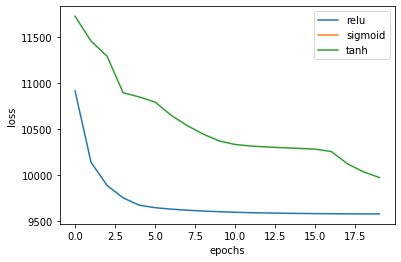

In [118]:
plt.plot( metrics_relu[0], label='relu')
plt.plot( metrics_sigm[0], label='sigmoid')
plt.plot( metrics_tanh[0], label='tanh')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

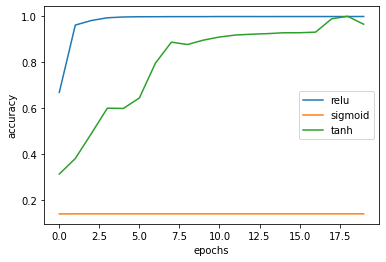

In [119]:
plt.plot( metrics_relu[1], label='relu')
plt.plot( metrics_sigm[1], label='sigmoid')
plt.plot( metrics_tanh[1], label='tanh')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [120]:
print('testing accuracies are: \n')
print('reLU :', acc_relu)
print('Sigmoid :', acc_sigm)
print('Tanh :', acc_tanh)

testing accuracies are: 

reLU : 0.998742665549036
Sigmoid : 0.1383067896060352
Tanh : 0.9388097233864208


##Subpart d: Weight initializations

###Random initialization

In [121]:
network_random= init( 8, [5], 6,['relu','relu','hi'])
metrics_random =train( network_random, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 50, 6)
acc_random= accuracy( network_random)

>>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.7294955987145452
>>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.8739695403101858
>>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.9172837781193237
>>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.9826743048763449
>>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.9953891295235434
>>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.9977644264356574
>>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.9977644264356574
>>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.9977644264356574
>>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.9977644264356574
>>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.9979041497834288
>>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.9984630431745145
>>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.9986027665222859
>>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.9991616599133715
>>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.9994411066089144
>>>>epoch:  14 , learning rate

###Constant Initialization

In [122]:
network_k= init_k( 8, [5], 6,['relu','relu','hi'])
metrics_k =train( network_k, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 50, 6)
acc_k= accuracy( network_k)

>>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.2172698057845466
>>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.2721810814587117
>>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.34413860556098924
>>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.4119044292301244
>>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.4553583903870337
>>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.46947044851194636
>>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.47282380885846026
>>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.4714265753807461
>>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.4722649154673746
>>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.4717060220762889
>>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.46695542825206093
>>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.46639653486097526
>>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.46346234455777563
>>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.45982953751571887
>>>>epoch:  14 , learni

###Zero Initialization

In [123]:
network_zero= init_zero( 8, [5], 6,['relu','relu','hi'])
metrics_zero =train( network_zero, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 50, 6)
acc_zero= accuracy( network_zero)

>>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.2139164454380327
>>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.2140561687858041
>>>>epoch:  14 , learning rate

###Analysis

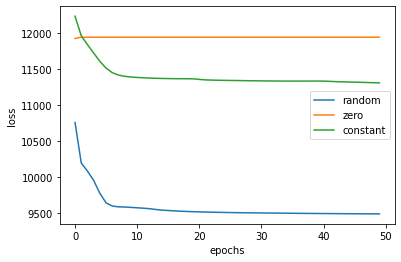

In [124]:
plt.plot( metrics_random[0], label='random')
plt.plot( metrics_zero[0], label='zero')
plt.plot( metrics_k[0], label='constant')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

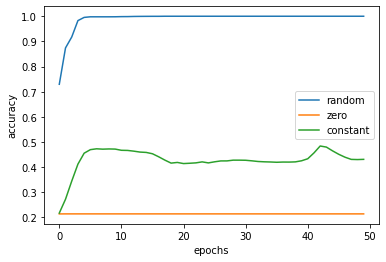

In [125]:
plt.plot( metrics_random[1], label='random')
plt.plot( metrics_zero[1], label='zero')
plt.plot( metrics_k[1], label='constant')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [126]:
print('testing accuracies are: \n')
print('random :', acc_random)
print('zero :', acc_zero)
print('constant :', acc_k)

testing accuracies are: 

random : 1.0
zero : 0.22170997485331098
constant : 0.4237217099748533


##Subpart e: neurons in the layers

In [127]:
neuron_count = [1, 3, 5, 8, 15]

metric_list=[]
acc_list=[]
for count in neuron_count:
  network= init( 8, [count], 6,['relu','relu','hi'])
  metrics =train( network, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)
  acc= accuracy( network)
  metric_list.append( metrics)
  acc_list.append(acc )


>>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.4257370406594942
>>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.4622048344278329
>>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.4622048344278329
>>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.45284337012714826
>>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.4585720273857762
>>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.4320245913092078
>>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.42685482744166553
>>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.42741372083275114
>>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.4278328908760654
>>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.4285315076149225
>>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.4285315076149225
>>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.4282520609193796
>>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.42936984770155096
>>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.42978901774486516
>>>>epoch:  14 , learning

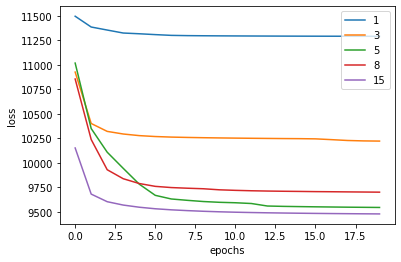

In [128]:
for i in range( len( neuron_count)):
  plt.plot( metric_list[i][0], label= neuron_count[i])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

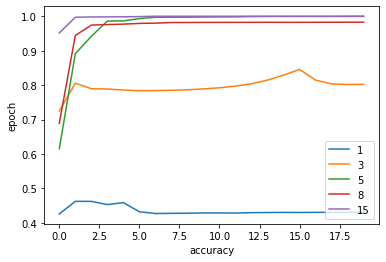

In [129]:
for i in range( len( neuron_count)):
  plt.plot( metric_list[i][1], label= neuron_count[i])
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend()
plt.show()

In [130]:
for i in range( len( neuron_count)):
  print(' with ', neuron_count[i], ' test accuracy is :', acc_list[i])

 with  1  test accuracy is : 0.4237217099748533
 with  3  test accuracy is : 0.8021793797150042
 with  5  test accuracy is : 0.998742665549036
 with  8  test accuracy is : 0.9832355406538139
 with  15  test accuracy is : 1.0


##Subpart f: Save and Load network

###Saving our model

In [131]:
import pickle 
model = network
with open('model', 'wb') as f: 
  pickle.dump(model, f)

###Loading model

In [133]:

my_model= '/content/my_model'
with open(my_model, 'rb') as f: 
  my_model = pickle.load(f) 
